In [175]:
import datetime as dt
# import holidays       
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [176]:
df = pd.read_csv("MRFST.csv", parse_dates=True, index_col='Date')

In [177]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
10-10-2018,61521.00000,64300.00000,61521.00000,63979.60156,63528.64844,6132
11-10-2018,62990.00000,64269.64844,61709.05078,63427.50000,62980.43359,6805
12-10-2018,63620.00000,64959.94922,63620.00000,63978.35156,63527.40625,11121
15-10-2018,63625.19922,64579.85156,62000.00000,62600.60156,62159.36719,12243
16-10-2018,62991.85156,63980.00000,62862.14844,63212.94922,62767.38672,6090


In [178]:
dfClose = pd.DataFrame(df['Close'])

In [179]:
dfClose

,Close
Date,
10-10-2018,63979.60156
11-10-2018,63427.50000
12-10-2018,63978.35156
15-10-2018,62600.60156
16-10-2018,63212.94922
...,...
04-10-2023,106901.39840
05-10-2023,106770.50000
06-10-2023,107550.25000


In [180]:
# seasonal_decompose(df['Close']) # error here proves theres no seasonality I THINK; Edit: That seems to be the case...
# Read the first answer: https://stats.stackexchange.com/questions/482089/statsmodels-seasonal-decompose-what-is-the-right-period-of-the-series-in-th

In [181]:
dfClose['shifted'] = dfClose['Close'].shift(1)
dfClose['shifted_diff'] = dfClose['Close']-dfClose['shifted']

In [182]:
dfClose.head()

,Close,shifted,shifted_diff
Date,,,
10-10-2018,63979.60156,NaN,NaN
11-10-2018,63427.50000,63979.60156,-552.10156
12-10-2018,63978.35156,63427.50000,550.85156
15-10-2018,62600.60156,63978.35156,-1377.75000
16-10-2018,63212.94922,62600.60156,612.34766


In [183]:
adfuller(dfClose['shifted_diff'].dropna(), autolag='AIC')

(-38.054805992183226,
 0.0,
 0,
 1234,
 {'1%': -3.435660336370594,
  '5%': -2.863885022214541,
  '10%': -2.568018522153254},
 20679.790570552774)

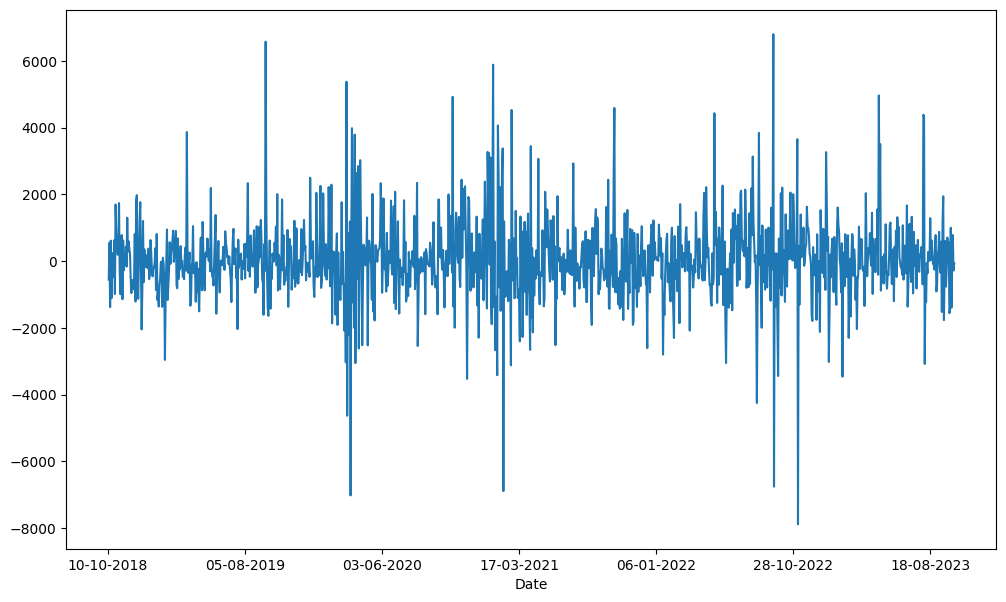

In [184]:
# p <0.05, move ahead with this
dfClose['shifted_diff'].plot(figsize=(12, 7));

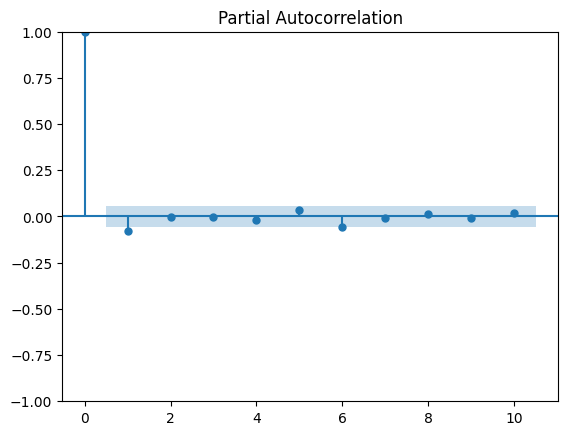

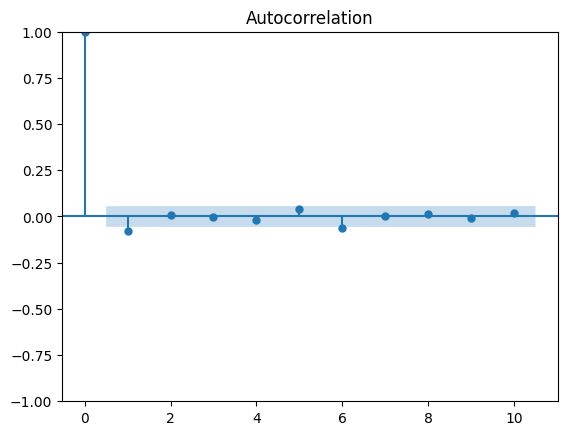

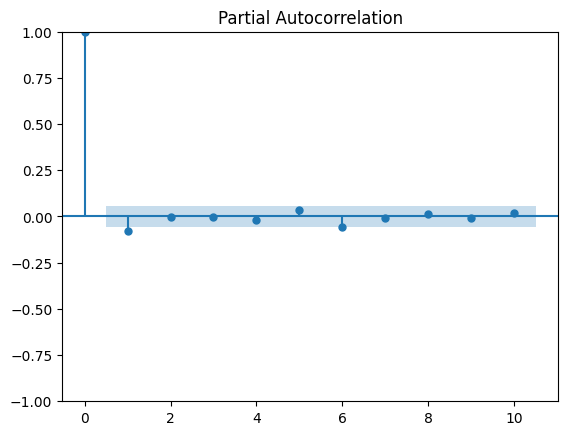

In [185]:
plot_acf(dfClose['shifted_diff'].dropna(), lags=10)
plot_pacf(dfClose['shifted_diff'].dropna(), lags=10)

In [186]:
# from acf, p = 1
# from pacf, q = 1
# 1-shift difference, d = 1

In [187]:
order = (1, 1, 1)

In [188]:
from sklearn.model_selection import TimeSeriesSplit

In [189]:
len(dfClose['Close'])

1236

In [190]:
train_len = np.round(0.7*1236)

In [191]:
test_len = np.round(len(dfClose['Close'])-train_len)

In [192]:
train_len, test_len

(865.0, 371.0)

In [193]:
#verification
train_len+test_len == len(dfClose['Close'])

True

In [194]:
trainingData = df['Close'].iloc[0:int(train_len)]

In [195]:
len(trainingData)

865

In [196]:
trainingData.head()

Date
10-10-2018    63979.60156
11-10-2018    63427.50000
12-10-2018    63978.35156
15-10-2018    62600.60156
16-10-2018    63212.94922
Name: Close, dtype: float64

In [197]:
trainingData.tail()

Date
05-04-2022    67756.04688
06-04-2022    67630.85156
07-04-2022    67109.25000
08-04-2022    67782.85156
11-04-2022    67765.64844
Name: Close, dtype: float64

In [198]:
testingData = df['Close'].iloc[int(train_len):int(train_len)+int(test_len)]

In [199]:
testingData

Date
12-04-2022     67585.70313
13-04-2022     67447.29688
18-04-2022     66944.95313
19-04-2022     66361.39844
20-04-2022     67670.39844
                  ...     
04-10-2023    106901.39840
05-10-2023    106770.50000
06-10-2023    107550.25000
09-10-2023    107266.95310
10-10-2023    107204.10160
Name: Close, Length: 371, dtype: float64

In [200]:
dfClose['Close'].tail()
# last value matches

Date
04-10-2023    106901.3984
05-10-2023    106770.5000
06-10-2023    107550.2500
09-10-2023    107266.9531
10-10-2023    107204.1016
Name: Close, dtype: float64

In [201]:
model_fit = ARIMA(trainingData, order=(1, 1, 0)).fit()

In [202]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  865
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -7342.262
Date:                Fri, 13 Oct 2023   AIC                          14688.524
Time:                        09:54:19   BIC                          14698.047
Sample:                             0   HQIC                         14692.169
                                - 865                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0526      0.018     -2.941      0.003      -0.088      -0.018
sigma2      1.405e+06   3.56e+04     39.420      0.000    1.34e+06    1.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.67   Jarque-Bera (JB):              1132.40
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [203]:
model_fit.predict()

Date
10-10-2018        0.000000
11-10-2018    62011.619085
12-10-2018    63456.534068
15-10-2018    63949.383227
16-10-2018    62673.055055
                  ...     
05-04-2022    67095.995026
06-04-2022    67723.118814
07-04-2022    67637.435366
08-04-2022    67136.680126
11-04-2022    67747.428016
Name: predicted_mean, Length: 865, dtype: float64

In [204]:
predictions = model_fit.predict()

In [205]:
np.sqrt(mean_squared_error(dfClose['Close'].iloc[1:865], predictions[1:]))

1186.838952727235

In [206]:
model_fit.predict(864) #this is the last value

Date
11-04-2022    67747.428016
dtype: float64

In [207]:
model_fit.predict(865) # observe: this is technically the prediction of the next value in the model after the last value with dates
# also observe: the next value after the last value with dates is technically the beginning of the testing data
# so model_fit.predict(866 will be prediction of the second value of the testing data) (Note: NOT the actual/realised value, this is what the model has predicted)
# logically, one needs values after the beginning of the testing data which the model has predicted (including the first value of the same)

865    67766.553122
dtype: float64

In [208]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
test_preds = pd.DataFrame({'predicted_test_values': [model_fit.predict(i).iloc[0] for i in range (865, 865+int(test_len))]});
# 865+test_len yields the last index/last value of the testing data

In [209]:
# Q. Why is the iloc[0] added above? Uncomment the following line and see what comes along with the predicted value (dtype: float64 also comes up in the list of values if you dont iloc it)
# model_fit.predict(865)

In [210]:
test_preds['actual_test_values'] = testingData.values

In [211]:
testingData #observe the dates here, they're needed for the next step

Date
12-04-2022     67585.70313
13-04-2022     67447.29688
18-04-2022     66944.95313
19-04-2022     66361.39844
20-04-2022     67670.39844
                  ...     
04-10-2023    106901.39840
05-10-2023    106770.50000
06-10-2023    107550.25000
09-10-2023    107266.95310
10-10-2023    107204.10160
Name: Close, Length: 371, dtype: float64

In [212]:
test_preds.index=testingData.index

In [213]:
test_preds #a perfectly new testing dataset to work on

,predicted_test_values,actual_test_values
Date,,
12-04-2022,67766.553122,67585.70313
13-04-2022,67766.505547,67447.29688
18-04-2022,67766.508049,66944.95313
19-04-2022,67766.507917,66361.39844
20-04-2022,67766.507924,67670.39844
...,...,...
04-10-2023,67766.507924,106901.39840
05-10-2023,67766.507924,106770.50000
06-10-2023,67766.507924,107550.25000


In [214]:
np.sqrt(mean_squared_error(test_preds['actual_test_values'], test_preds['predicted_test_values']))

24107.18355426506

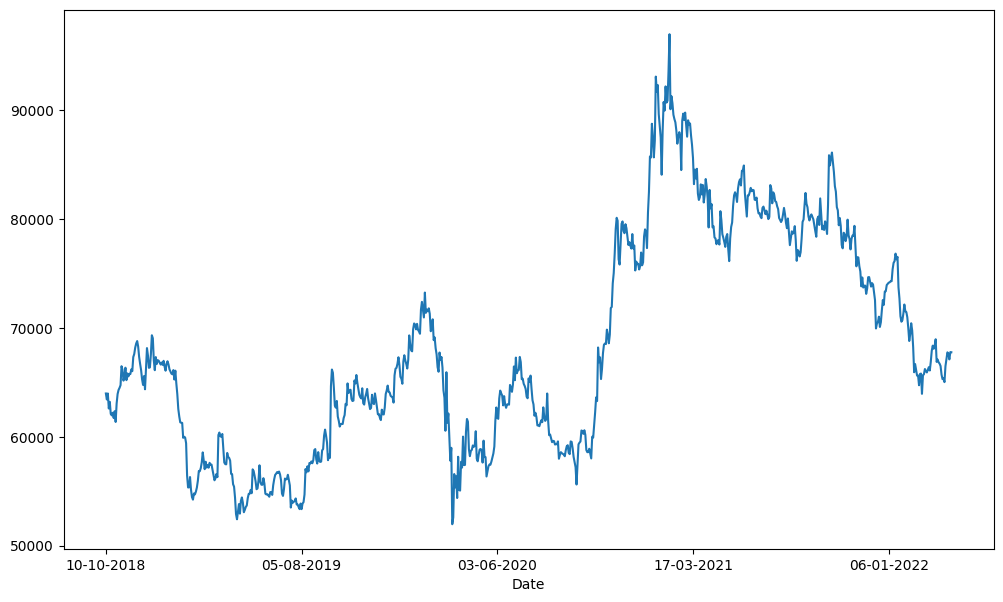

In [215]:
trainingData.plot(figsize=(12, 7));

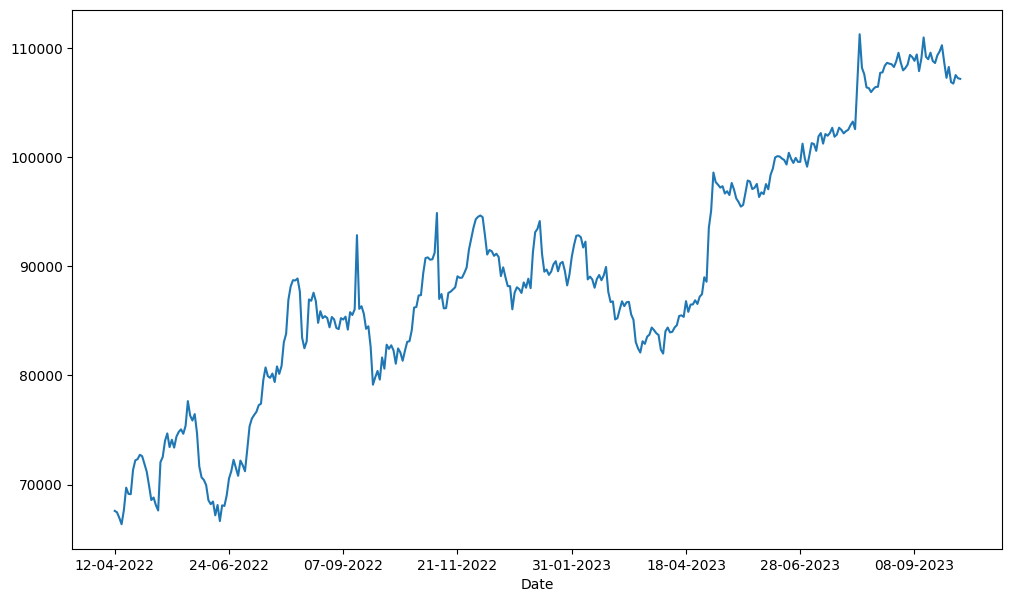

In [216]:
test_preds['actual_test_values'].plot(figsize=(12, 7));

In [217]:
model_fit.predict()['17-03-2021']

86863.93914578116

In [218]:
model_fit.predict().tail(100)

Date
17-11-2021    78446.937387
18-11-2021    79325.275445
22-11-2021    77565.161969
23-11-2021    75752.636378
24-11-2021    76457.165252
                  ...     
05-04-2022    67095.995026
06-04-2022    67723.118814
07-04-2022    67637.435366
08-04-2022    67136.680126
11-04-2022    67747.428016
Name: predicted_mean, Length: 100, dtype: float64

In [219]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [220]:
hw_model_fitted = ExponentialSmoothing(trainingData).fit()

In [221]:
hw_model_fitted.fittedvalues

Date
10-10-2018    64036.921612
11-10-2018    63985.166937
12-10-2018    63481.645569
15-10-2018    63930.124874
16-10-2018    62729.688998
                  ...     
05-04-2022    67053.817293
06-04-2022    67687.865286
07-04-2022    67636.387195
08-04-2022    67160.431344
11-04-2022    67722.418899
Length: 865, dtype: float64

In [222]:
np.sqrt(mean_squared_error(trainingData, hw_model_fitted.fittedvalues))

1183.940966884218

In [223]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', FutureWarning)

hw_test_preds = pd.DataFrame({'predicted_test_values': [hw_model_fitted.predict(i).iloc[0] for i in range (865, 865+int(test_len))]});
# 865+test_len yields the last index/last value of the testing data

In [224]:
hw_test_preds['actual_test_values'] = testingData.values

In [225]:
hw_test_preds #observe the dates here, they're needed for the next step

,predicted_test_values,actual_test_values
0,67761.451153,67585.70313
1,67761.451153,67447.29688
2,67761.451153,66944.95313
3,67761.451153,66361.39844
4,67761.451153,67670.39844
...,...,...
366,67761.451153,106901.39840
367,67761.451153,106770.50000
368,67761.451153,107550.25000
369,67761.451153,107266.95310


In [226]:
hw_test_preds.index=testingData.index

In [227]:
test_preds #a perfectly new testing dataset to work on

,predicted_test_values,actual_test_values
Date,,
12-04-2022,67766.553122,67585.70313
13-04-2022,67766.505547,67447.29688
18-04-2022,67766.508049,66944.95313
19-04-2022,67766.507917,66361.39844
20-04-2022,67766.507924,67670.39844
...,...,...
04-10-2023,67766.507924,106901.39840
05-10-2023,67766.507924,106770.50000
06-10-2023,67766.507924,107550.25000


In [228]:
np.sqrt(mean_squared_error(test_preds['actual_test_values'], test_preds['predicted_test_values']))

24107.18355426506

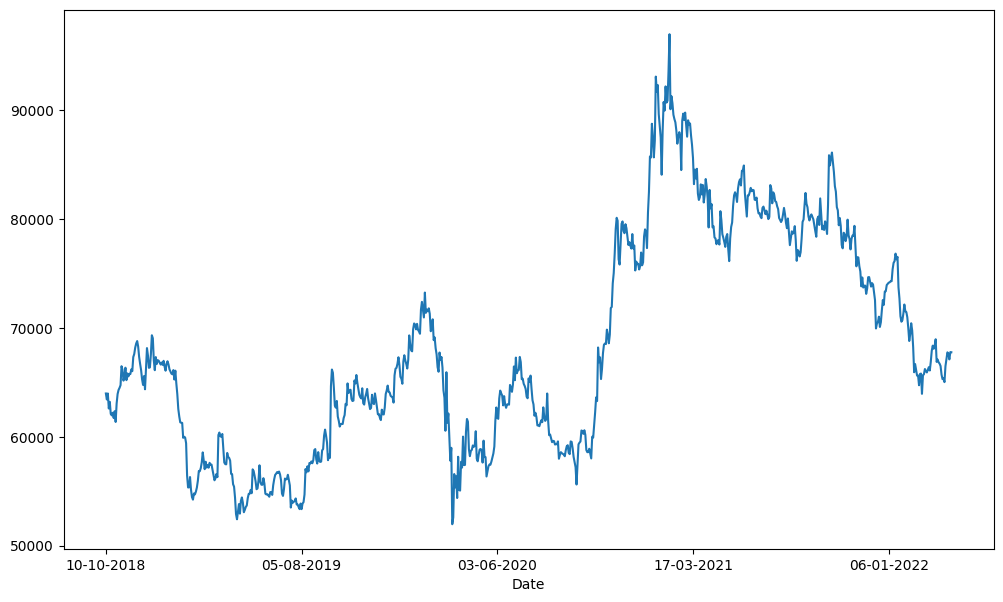

In [229]:
trainingData.plot(figsize=(12, 7));

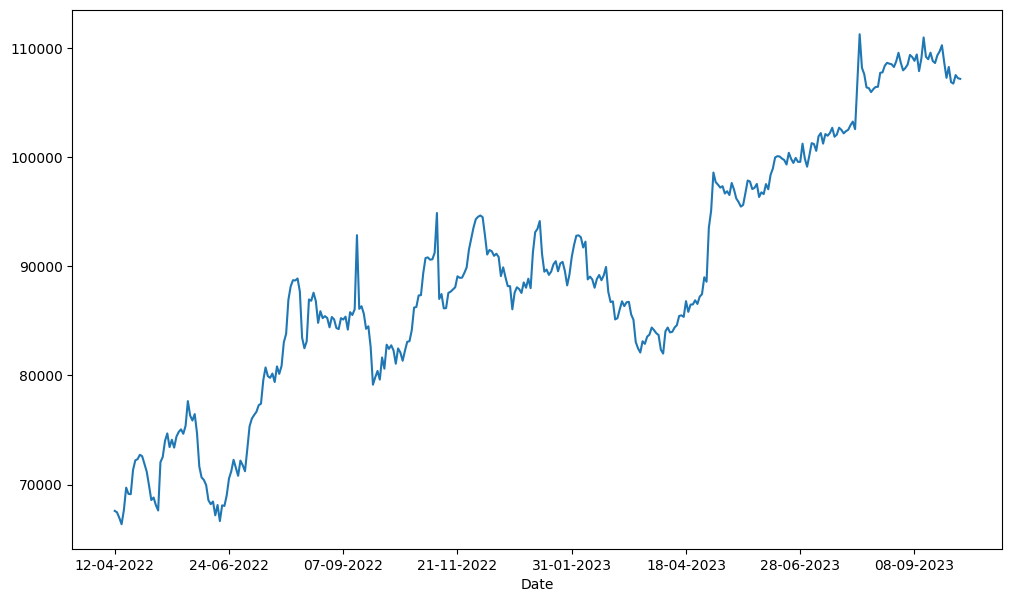

In [230]:
test_preds['actual_test_values'].plot(figsize=(12, 7));

In [231]:
model_fit.predict()['17-03-2021']

86863.93914578116

In [232]:
model_fit.predict().tail(100)

Date
17-11-2021    78446.937387
18-11-2021    79325.275445
22-11-2021    77565.161969
23-11-2021    75752.636378
24-11-2021    76457.165252
                  ...     
05-04-2022    67095.995026
06-04-2022    67723.118814
07-04-2022    67637.435366
08-04-2022    67136.680126
11-04-2022    67747.428016
Name: predicted_mean, Length: 100, dtype: float64

In [233]:
df['Close_rolling_5'] = df['Close'].rolling(window=10).sum()

In [234]:
plot= df['Close_rolling_5'].dropna()

<Axes: xlabel='Date'>

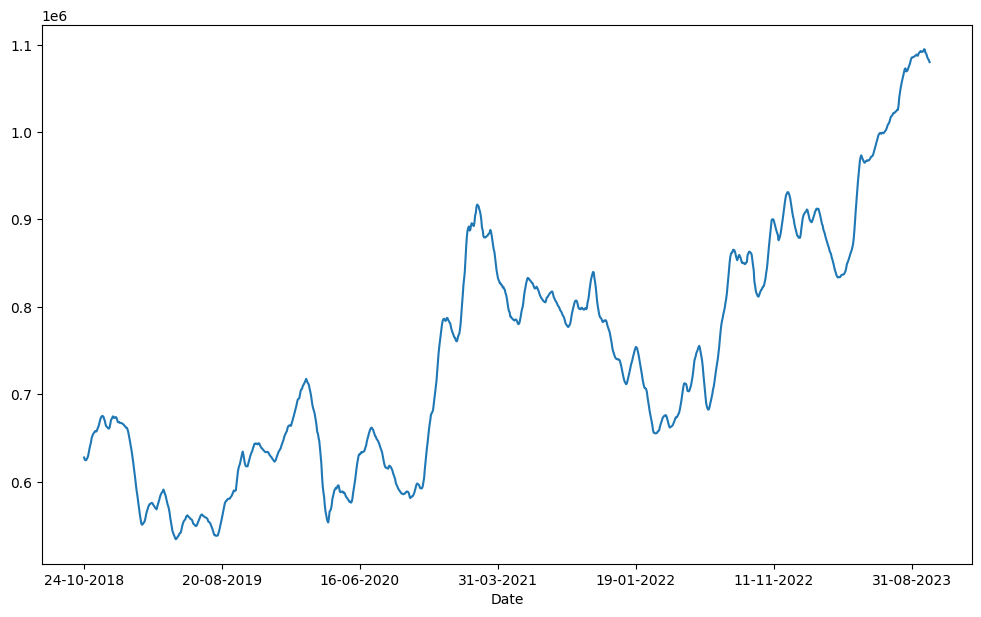

In [235]:
plot.plot(figsize=(12, 7))

<Axes: xlabel='Date'>

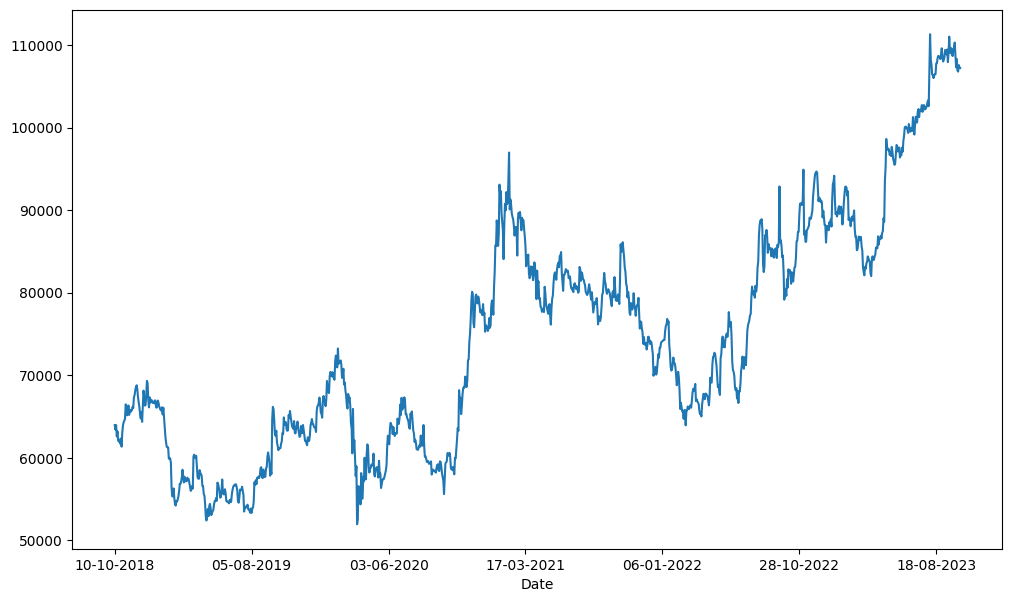

In [236]:
df['Close'].plot(figsize=(12, 7))

In [237]:
sample_train_len = int(np.round(0.5*len(df['Close'])))
sample_test_len = int(np.round(len(dfClose['Close'])-train_len))

In [238]:
sample_train = df['Close'].iloc[0:int(sample_train_len)]
sample_test = df['Close'].iloc[int(sample_train_len):int(sample_train_len)+int(sample_test_len)]

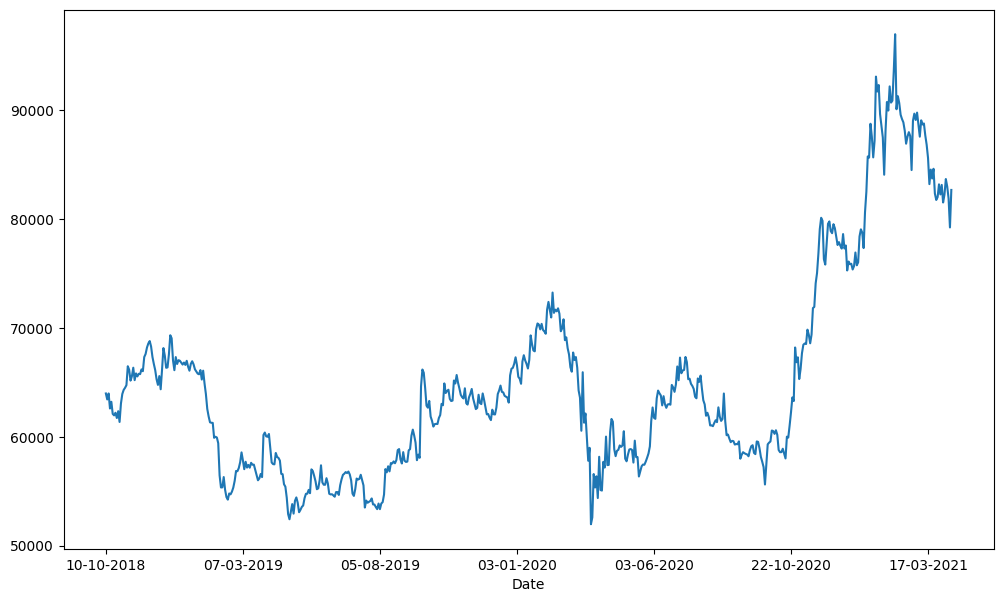

In [239]:
sample_train.plot(figsize=(12, 7));

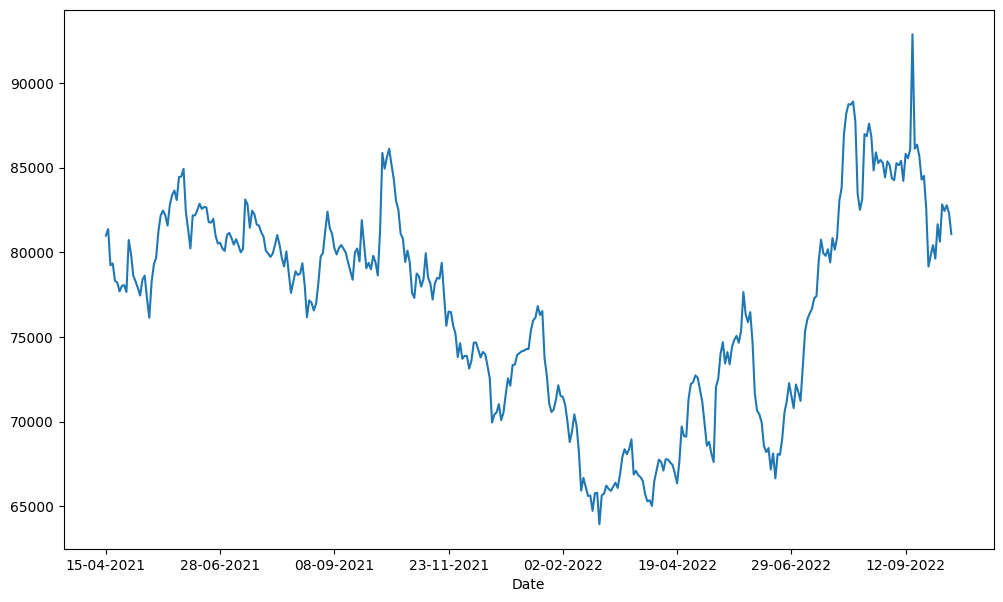

In [240]:
sample_test.plot(figsize=(12, 7));

In [241]:
training_preds = pd.DataFrame(data= {'Actual': trainingData.iloc[1:], 'predicted': predictions.iloc[1:]})

In [242]:
predictions

Date
10-10-2018        0.000000
11-10-2018    62011.619085
12-10-2018    63456.534068
15-10-2018    63949.383227
16-10-2018    62673.055055
                  ...     
05-04-2022    67095.995026
06-04-2022    67723.118814
07-04-2022    67637.435366
08-04-2022    67136.680126
11-04-2022    67747.428016
Name: predicted_mean, Length: 865, dtype: float64

In [243]:
trainingData

Date
10-10-2018    63979.60156
11-10-2018    63427.50000
12-10-2018    63978.35156
15-10-2018    62600.60156
16-10-2018    63212.94922
                 ...     
05-04-2022    67756.04688
06-04-2022    67630.85156
07-04-2022    67109.25000
08-04-2022    67782.85156
11-04-2022    67765.64844
Name: Close, Length: 865, dtype: float64

In [244]:
training_preds

,Actual,predicted
Date,,
11-10-2018,63427.50000,62011.619085
12-10-2018,63978.35156,63456.534068
15-10-2018,62600.60156,63949.383227
16-10-2018,63212.94922,62673.055055
17-10-2018,62101.85156,63180.746913
...,...,...
05-04-2022,67756.04688,67095.995026
06-04-2022,67630.85156,67723.118814
07-04-2022,67109.25000,67637.435366


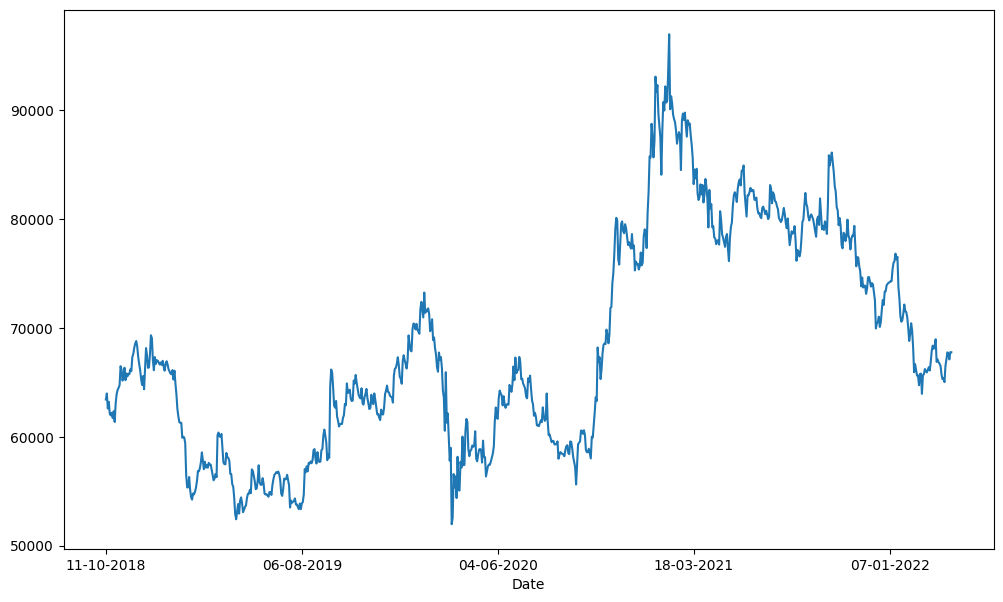

In [245]:
training_preds['Actual'].plot(figsize=(12, 7));

In [246]:
training_preds['errors'] = np.square(training_preds['Actual']-training_preds['predicted'])

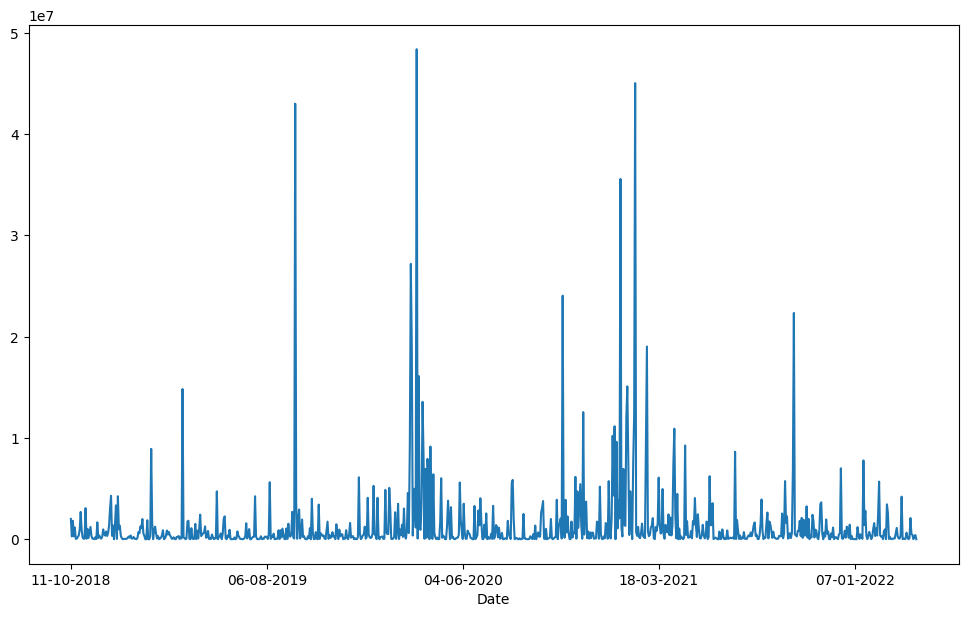

In [247]:
training_preds['errors'].plot(figsize=(12, 7));

In [248]:
test_preds['errors'] = np.square(test_preds['predicted_test_values']-test_preds['actual_test_values'])

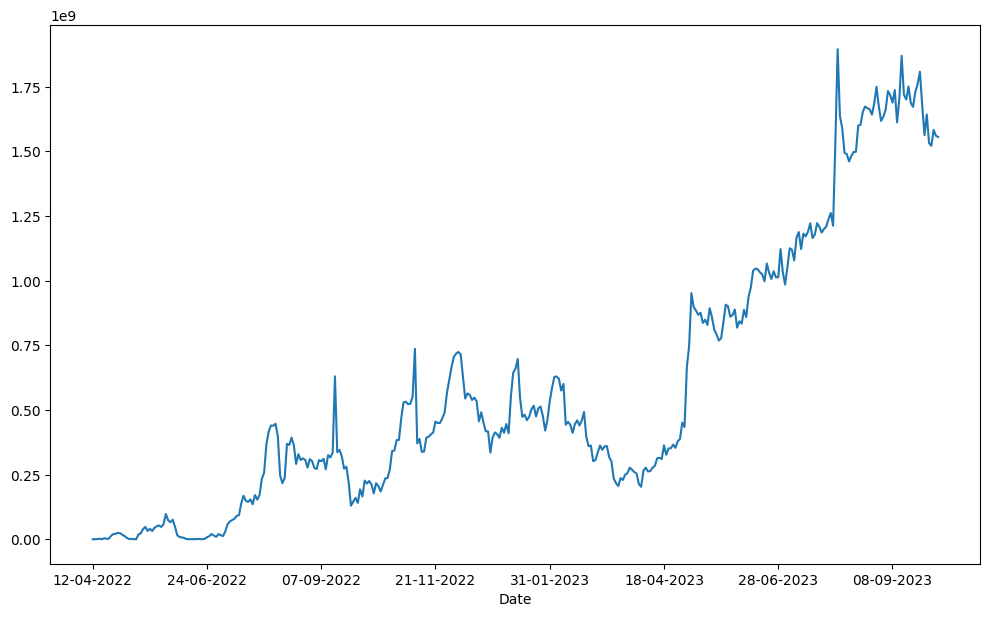

In [249]:
test_preds['errors'].plot(figsize=(12, 7));

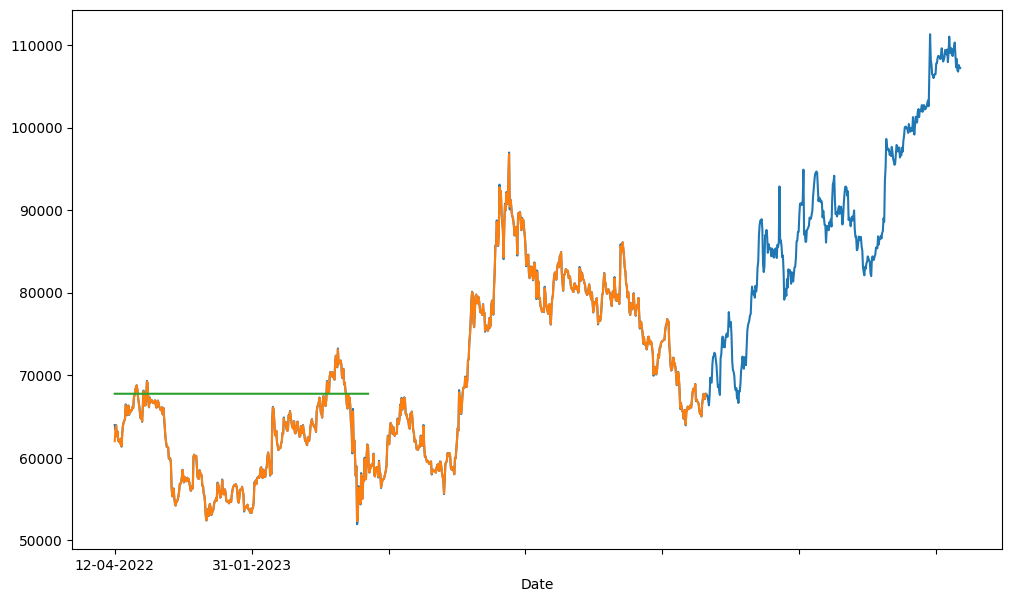

In [250]:
df['Close'].plot(figsize=(12, 7))
training_preds['predicted'].plot(figsize=(12, 7))
test_preds['predicted_test_values'].plot(figsize=(12, 7))
plt.show()

<Axes: xlabel='Date'>

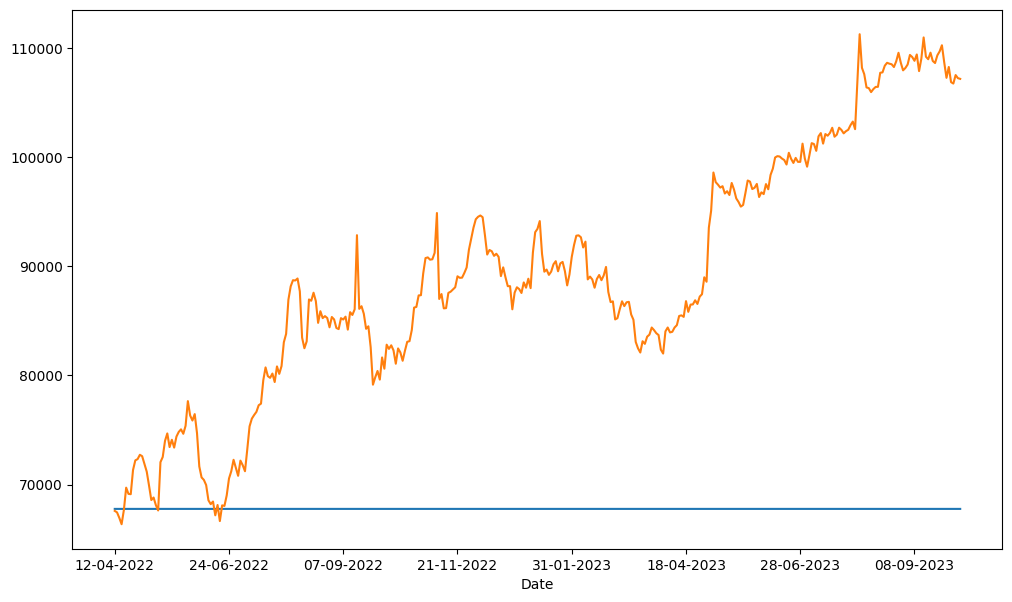

In [251]:
test_preds['predicted_test_values'].plot(figsize=(12, 7))
test_preds['actual_test_values'].plot(figsize=(12, 7))

<Axes: xlabel='Date'>

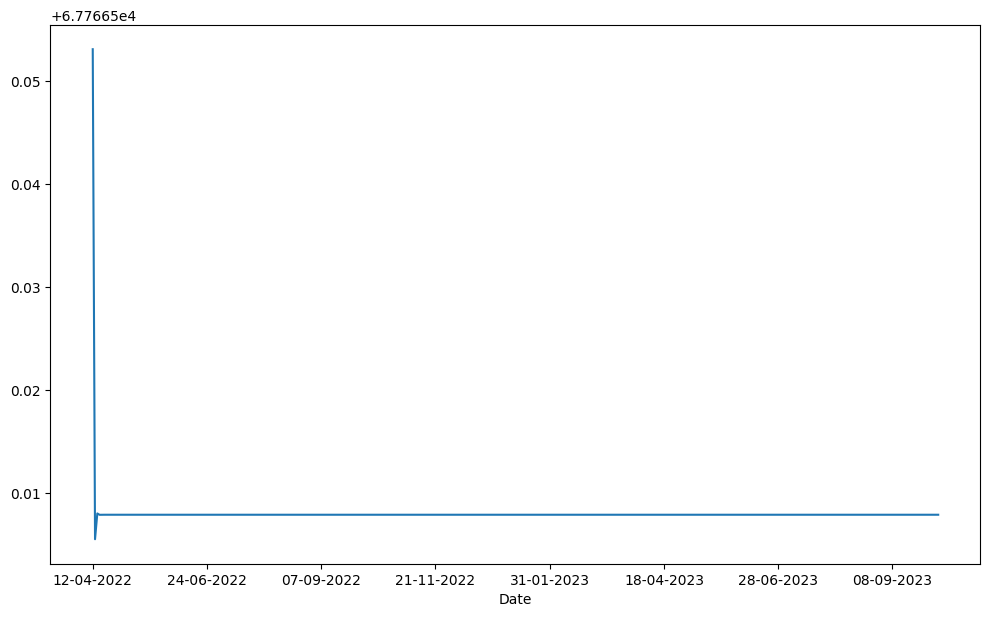

In [252]:
test_preds['predicted_test_values'].plot(figsize=(12, 7))

In [253]:
test_preds

,predicted_test_values,actual_test_values,errors
Date,,,
12-04-2022,67766.553122,67585.70313,3.270672e+04
13-04-2022,67766.505547,67447.29688,1.018942e+05
18-04-2022,67766.508049,66944.95313,6.749525e+05
19-04-2022,67766.507917,66361.39844,1.974333e+06
20-04-2022,67766.507924,67670.39844,9.237033e+03
...,...,...,...
04-10-2023,67766.507924,106901.39840,1.531540e+09
05-10-2023,67766.507924,106770.50000,1.521311e+09
06-10-2023,67766.507924,107550.25000,1.582746e+09


In [254]:
test_preds.iloc[150]

predicted_test_values    6.776651e+04
actual_test_values       8.909720e+04
errors                   4.549986e+08
Name: 21-11-2022, dtype: float64

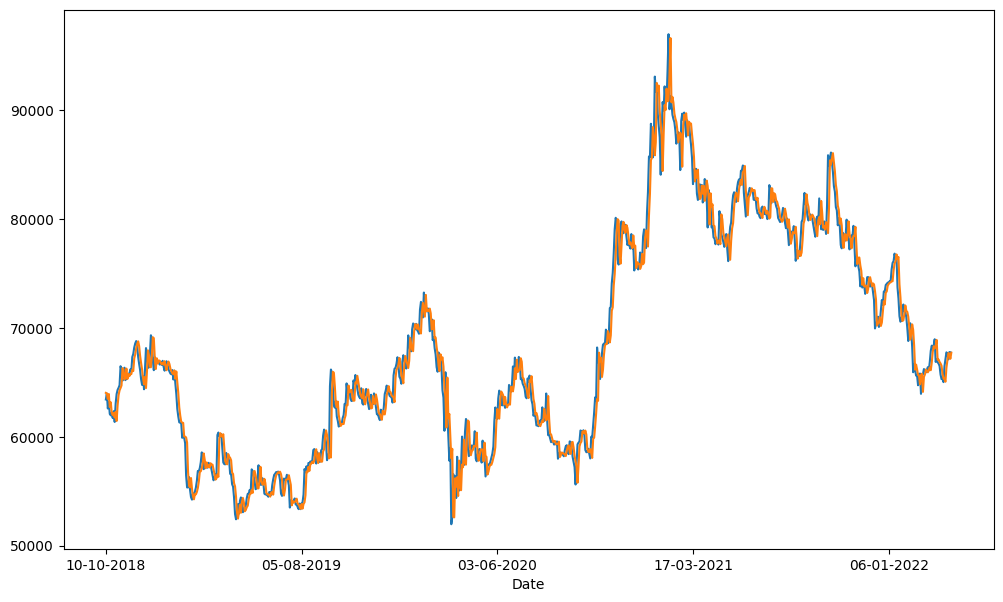

In [260]:
training_preds['Actual'].plot(figsize=(12, 7))
hw_model_fitted.fittedvalues.plot()
plt.show()